# Demo: Change Point Detection

This demonstration shows a very simple computational model to show how change point detection works. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# specify a plotting enviornment (i.e. a set of defaults)
sns.set_context('talk')

Here, we generate a random sequency of numbers to learn. The sequence of numbers is a normally distributed variable, with a discrete change-point after which the mean changes.

In [2]:

mu1 = 15 # mean prior to change point
mu2 = 5 # mean following change point
stdev = 3
N = 50

X = np.random.normal(mu1, stdev, N)
Y = np.random.normal(mu2, stdev, N)

We train a simple delta rule model to learn the values with fixed weights. The learner updates its estimate after each time point as follows:

$$ V_{t+1} = V_{t} + \eta \left (X_t - V_{t} \right ) $$

where $\eta$ is the learning rate. Note, for the special case that $\eta =\frac{1}{t}$, that the estimate $V$ is equal to the simple average, or $V=\frac{1}{N}\sum_{t=1}{N}X_t$

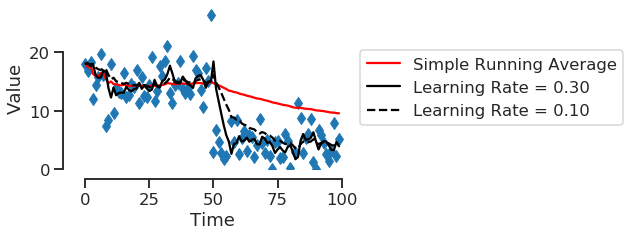

In [3]:

# set the learning rates of the models!
learning_rate0 = 0.3
learning_rate1 = 0.1

# create a simple RL Agent (average all trials, eta = 1/t)
XY = np.concatenate([X, Y])
mle = [np.mean(XY[0:ii]) for ii in range(1, len(XY) + 1)]

# RL agent
v = X[0]
q = []
for X0 in XY:
    q.append(v)
    v += learning_rate0 *(X0 - v)

# RL agent
v = X[0]
q2 = []
for X0 in XY:
    q2.append(v)
    v += learning_rate1 *(X0 - v)
    
# plot the results
with sns.axes_style('ticks'):
    plt.figure(figsize=(5, 3))
    plt.plot(XY, 'd')
    plt.plot(mle, 'r', label='Simple Running Average')
    plt.plot(q, 'k', label='Learning Rate = %.2f' % learning_rate0)
    plt.plot(q2, 'k--', label='Learning Rate = %.2f' % learning_rate1)
    ax = plt.gca()
    lb, ub = ax.get_ylim()
    ax.set_ylim([0, ub])
    sns.despine(trim=True, offset=10)
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We can also look at how well the models due over all time by looking at their cummulative loss.  Loss here is the *Mean Squared Error*, defined:

$$ \text{MSE} = \sum_{i}||\hat{x}_i - x_i||^2 $$ 

It's helpful to break this down across time as well.

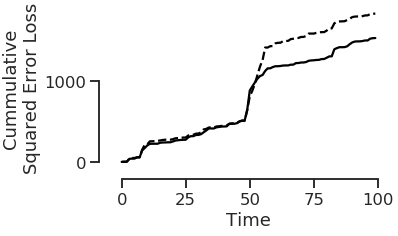

In [4]:
ml_error = []
q_error = []
q2_error = []

# calculate the error term
for ii, X0 in enumerate(XY):
    ml_error.append((X0-mle[ii])**2)
    q_error.append((X0-q[ii])**2)
    q2_error.append((X0-q2[ii])**2)
    
# plot across time
with sns.axes_style('ticks'):
    plt.figure(figsize=(5, 3))
    plt.plot(np.cumsum(q_error), 'k', label='Learning Rate = %.2f' % learning_rate0)
    plt.plot(np.cumsum(q2_error), 'k--', label='Learning Rate = %.2f' % learning_rate1)
    ax = plt.gca()
    ax.set_ylabel('Cummulative\nSquared Error Loss')
    ax.set_xlabel('Time')
    sns.despine(trim=True, offset=10)

To see how the effect of learnign rate effects cumulative performance, we can look at a range of learning rates

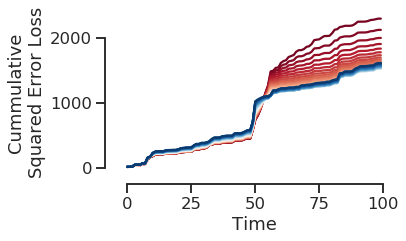

In [5]:

etas =  np.arange(0.05, 0.51, 0.01)

CC = sns.color_palette('RdBu', len(etas)) 
with sns.axes_style('ticks'):
    plt.figure(figsize=(5, 3))

    for ii, eta in enumerate(etas):
        q_error = []
        v = 15
        for X0 in XY:
            q_error.append((X0-v)**2)
            v += eta *(X0 - v)
        plt.plot(np.cumsum(q_error), color=CC[ii])
        
    ax = plt.gca()
    ax.set_ylabel('Cummulative\nSquared Error Loss')
    ax.set_xlabel('Time')
    sns.despine(trim=True, offset=10)


# Learning rate as forgetting

Although we often think of the "learning rate" as the rate by which we integrate new information, an equally valid view is as the learning rate as the rate by which we forget old information.

A higher learning rate weights more recent experiences more strongly and decays experiences more distant in time more quickly. Specifically, the model's learned value is a weighted sum of all of the previous observations, such that

$$ V_t = \sum_{k=0}^{t}w_ix_i$$

where $w_i$ is the contribution (weight) of an observation at time $i$. Using a fixed learning rate, the each individual observation's contribution to the mean decays.  This can be shown by unraveling the recursive sum:

$$ V_{t+1} = V_{t} + \eta \left (x_t - V_{t} \right ) $$

$$ V_{t+1} =  \eta x_{t} + \eta\left (1 - \eta \right ) x_{t-1} + \eta\left (1 - \eta \right )^2 x_{t-2} +  \eta\left (1 - \eta \right )^3 x_{t-3} + ... $$ 

$$ V_{t+1} = \sum_{k=0}^{t}\eta\left (1 - \eta \right )^k X_{t-k} $$ 



Hense, with a fixed learning rate, this weight for the observation at $i=t-k$ is equal to:

$$ w_i = \eta(1-\eta)^{t-i} $$

and the contribution of each observation point decays with time.


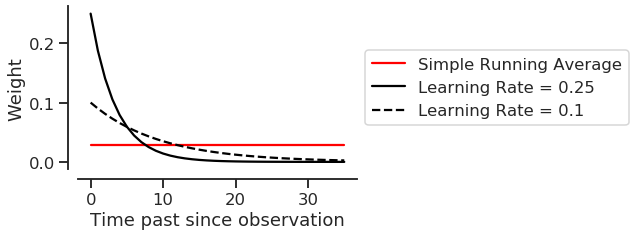

In [6]:
# calculate the weight
def weight(eta, k):
    return eta * ((1-eta)**k)

# plot over time
with sns.axes_style('ticks'):
    plt.figure(figsize=(5, 3))
    x = range(36)
    ax = plt.gca()
    ax.plot(x, np.ones(len(x))/len(x), 'r', label='Simple Running Average')
    ax.plot(x, [weight(0.25, k) for k in x],'k', label='Learning Rate = 0.25')
    ax.plot(x, [weight(0.1, k) for k in x],'k--', label='Learning Rate = 0.1')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Weight')
    ax.set_xlabel('Time past since observation')
    sns.despine(trim=False, offset=10)


One notable consequence of this is that lower learning rates result in an algorithm that integrates over a larger period of time.

# The optimal thing to do after a change point, is to reset and start over

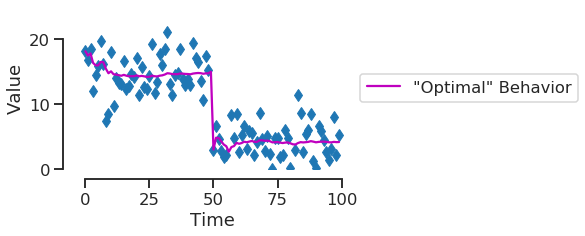

In [7]:
# create a simple RL Agent
XY = np.concatenate([X, Y])
mle = [
    np.mean(X[0:ii]) for ii in range(1, len(X) + 1)] + [np.mean(Y[0:ii]) for ii in range(1, len(Y) + 1)]



v = 10
eta = 0.25
q = []
for X0 in XY:
    q.append(v)
    v += eta *(X0 - v)
    

with sns.axes_style('ticks'):
    plt.figure(figsize=(5, 3))
    plt.plot(XY, 'd')
    plt.plot(mle, 'm', label='"Optimal" Behavior')
    ax = plt.gca()
    ax.set_ylim([0, 25])
    sns.despine(trim=True, offset=10)
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We can also show the optimal effective learning rate over time.  It's worth noting that this is uneffected by the variance only because we know the location of the change point.

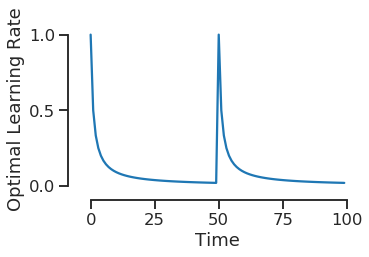

In [8]:
x = np.arange(0, 100)
y = np.concatenate([1 / np.arange(1, 51)] * 2)

with sns.axes_style('ticks'):
    plt.figure(figsize=(5, 3))
    plt.plot(x, y,)
    ax = plt.gca()
    sns.despine(trim=True, offset=10)
    ax.set_ylabel('Optimal Learning Rate')
    ax.set_xlabel('Time')

Here is a demonstration of what a Bayesian learner learning the probability of a binary reward (Bernoulli random variable). This can be parameterized with a Beta distribution with two parameters: "a" the number of sucesses and "b" the number of failures

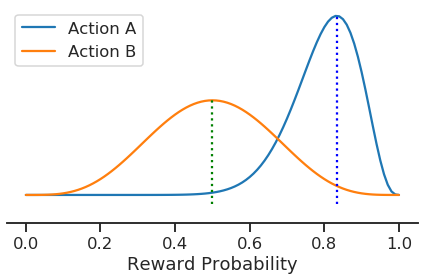

In [9]:
from scipy.stats import beta


a = 16  # number of times option A was tried & rewarded
b = 4  # number of times option A was tried & not rewarded
mode_a = (a - 1.) / (a + b -2.)
rv = beta(a, b)


a = 5 # number of times option A was tried & rewarded
b = 5 # number of times option B was tried & not rewarded
mode_b = (a - 1.) / (a + b -2.)
rv2 = beta(a, b)

x = np.arange(0, 1.01, 0.01)
with sns.axes_style('ticks'):
    plt.figure(figsize=(6, 4))
    plt.plot(x, rv.pdf(x), label='Action A')
    plt.plot(x, rv2.pdf(x), label='Action B')
    
    ax = plt.gca()
    lb, ub = ax.get_ylim()
    plt.plot([mode_a, mode_a], [lb, rv.pdf(mode_a)], 'b:')

    plt.plot([mode_b, mode_b], [lb, rv2.pdf(mode_b)], 'g:')

    
    ax.set_yticks([])
    ax.set_xlabel('Reward Probability')
    sns.despine(offset=10, left=True)
    plt.legend(loc='upper left')
    plt.tight_layout()


The probability that "A" or "B" can be dervied via integration or sampleing. Here, we use sampling

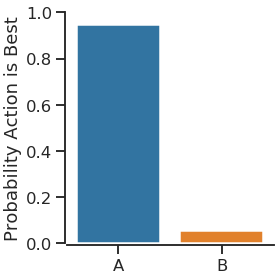

In [10]:
cmf = rv.cdf(x)
cmf2 = rv2.cdf(x)

y = [x[np.sum(cmf < np.random.rand())] > x[np.sum(cmf2 < np.random.rand())] for _ in range(1000)]

with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.barplot([1, 2], [np.sum(y)*1./len(y), (len(y) - np.sum(y))*1./len(y)])
    
    ax = plt.gca()
    ax.set_xticklabels(['A', 'B'])
    ax.set_ylabel('Probability Action is Best')
    ax.set_ylim(0, 1)
    sns.despine(offset=2)
    plt.tight_layout()
